In [3]:
import shap
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from evaluation import evaluate_global_shap_scores
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("numba").setLevel(logging.WARNING)
logging.getLogger("shap").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from evaluation import evaluate_global_shap_scores
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

from shapflow import flow
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from shapflow.flow import Node, Graph, GraphExplainer
from on_manifold import OnManifoldExplainer, IndExplainer


c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
DEBUG:matplotlib:matplotlib data path: c:\Users\snorl\Desktop\FYP\venv\Lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\snorl\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:CACHEDIR=C:\Users\snorl\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\snorl\.matplotlib\fontlist-v390.json


In [4]:
print("Starting ML Pipeline...")
base_dir = '../../'
print(f"Base directory set to: {base_dir}")

data_path = base_dir + 'dataset/' + 'Real_World_IBS.xlsx'
result_dir = base_dir + 'result/'

print("Loading data...")
df = pd.read_excel(data_path)
df = df.drop(columns=['HAD_Anxiety', 'Patient', 'Batch_metabolomics', 'BH', 'Sex', 'Age', 'BMI','Race','Education','HAD_Depression','STAI_Tanxiety', 'Diet_Category','Diet_Pattern'])
print("Data loaded successfully.")

print(len(df))

Starting ML Pipeline...
Base directory set to: ../../
Loading data...
Data loaded successfully.
368


In [5]:
print("Encoding labels...")
label_encoder = LabelEncoder()
df['Group'] = label_encoder.fit_transform(df['Group'])
df_encoded = df

print("Labels encoded successfully.")

X = df_encoded.drop(columns=['Group'])
y = df_encoded['Group']

print("Training Random Forest model...")
param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
estimator=rf, param_distributions=param_dist, n_iter=50,
        cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)
model = random_search.best_estimator_
best_params = random_search.best_params_
print("Model trained successfully.")

Encoding labels...
Labels encoded successfully.
Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Model trained successfully.


In [11]:
X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine", "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)", "tricarballylate","succinimide", "thymine", "syringic acid", "serotonin", "ribitol" ]]
y = df_encoded['Group']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)


param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
estimator=rf, param_distributions=param_dist, n_iter=50,
            cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)
model = random_search.best_estimator_
best_params = random_search.best_params_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


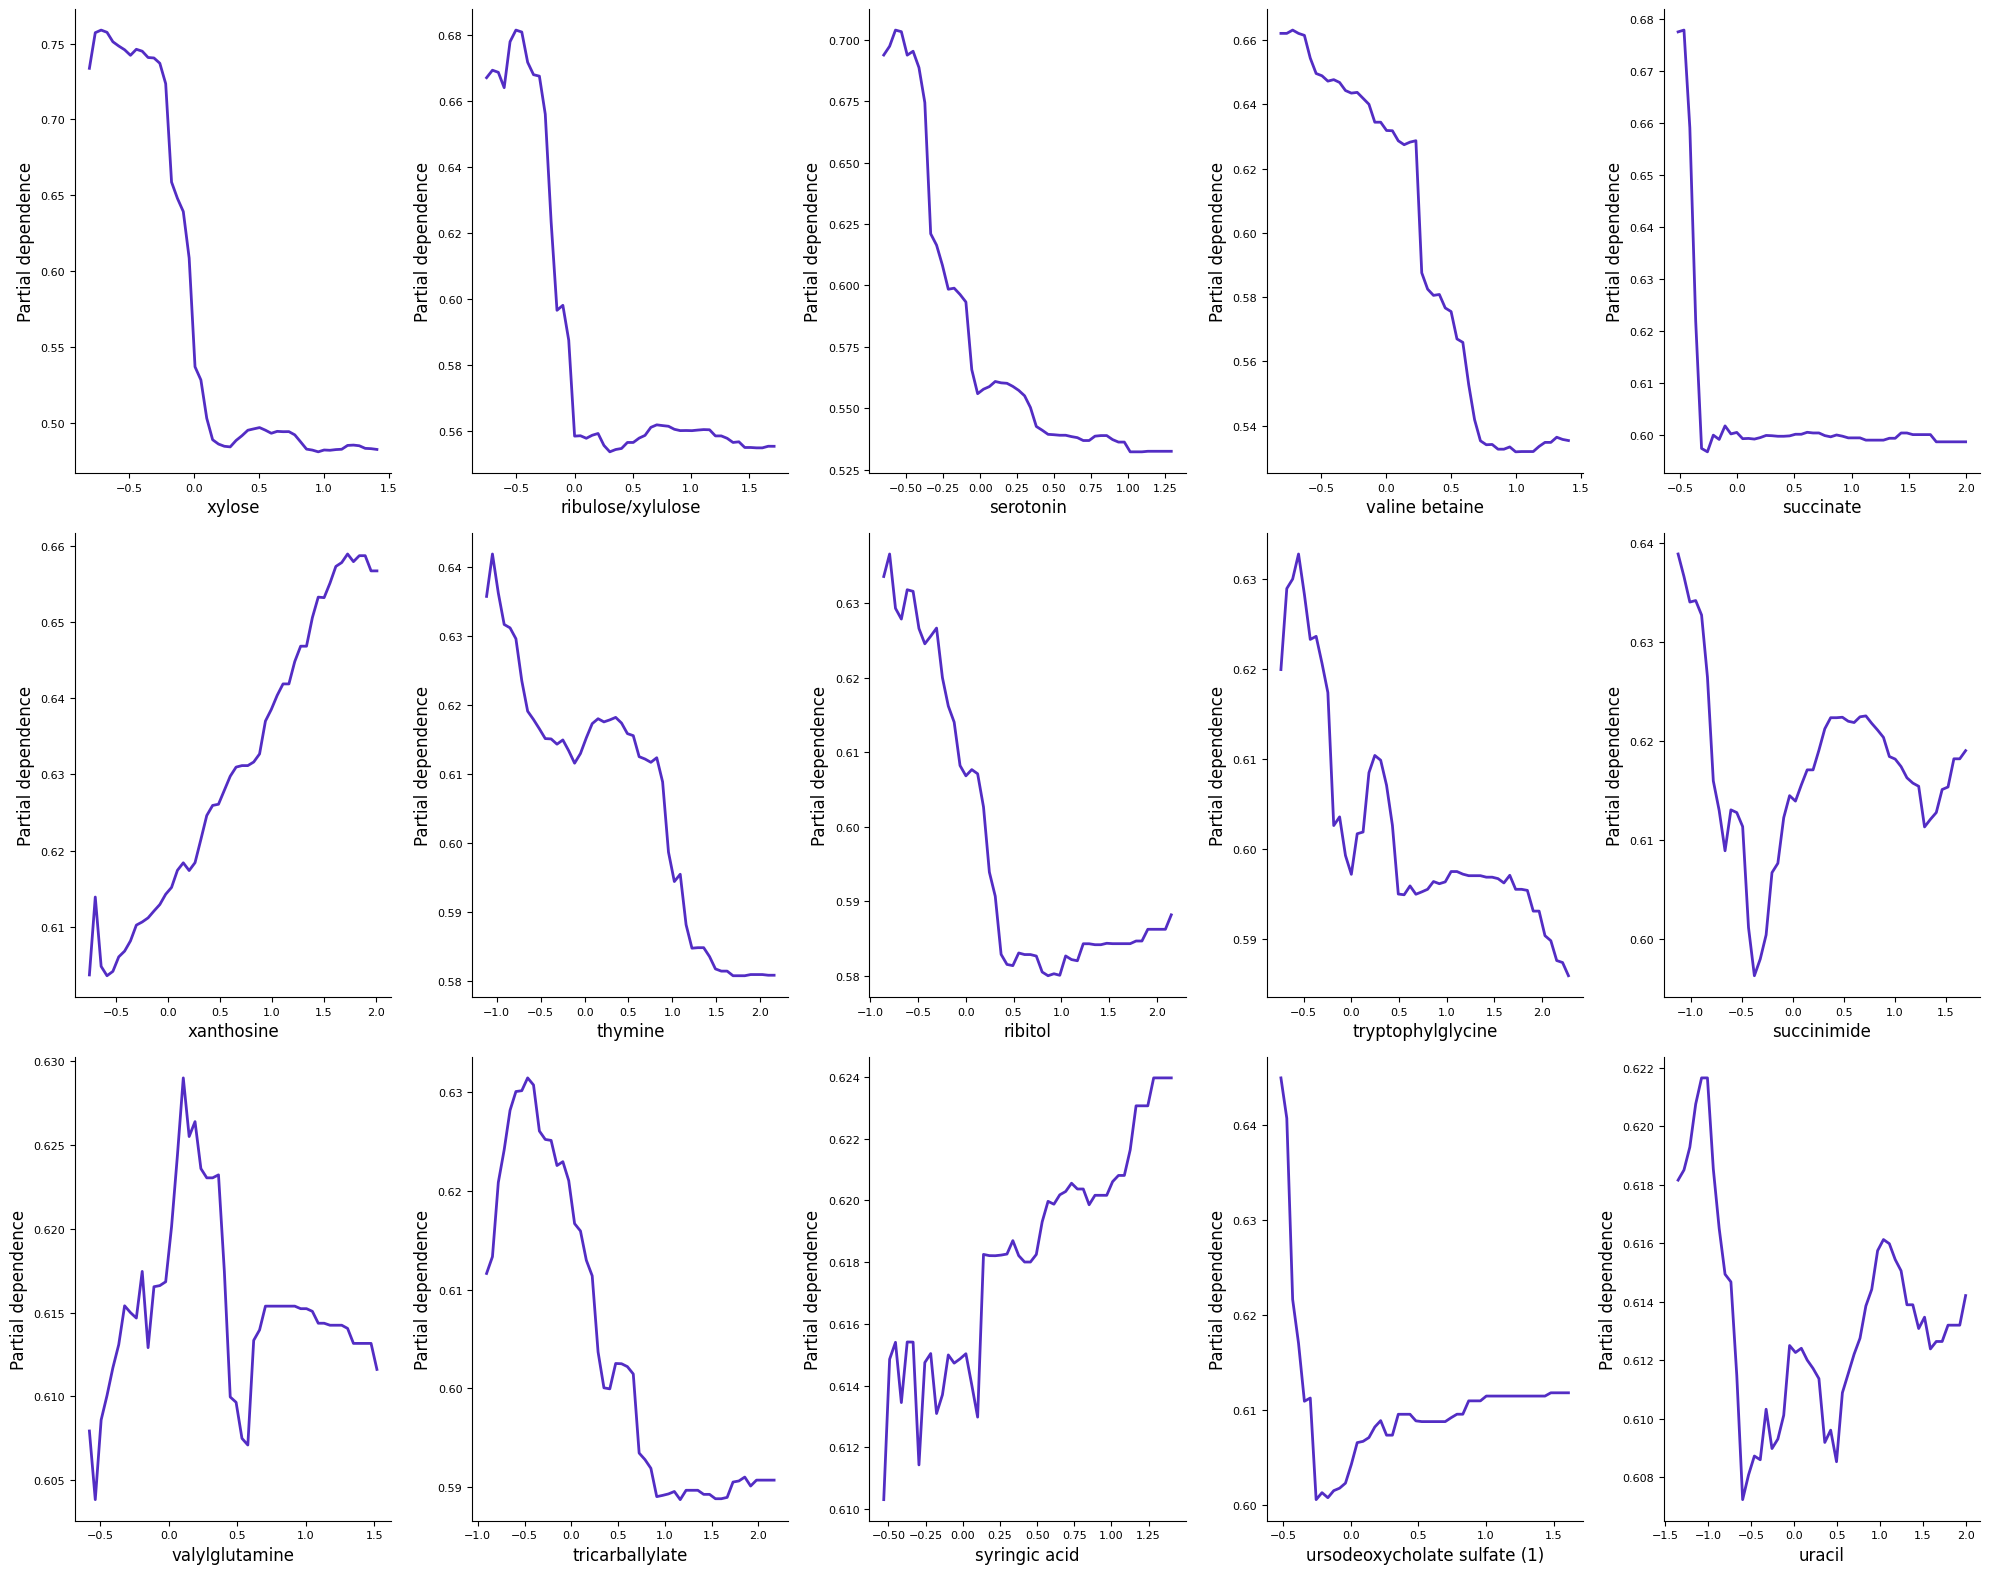

In [16]:
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_  # Use model instead of rf
})
top_20_features = importances.nlargest(15, 'importance')['feature'].values

fig, axes = plt.subplots(3, 5, figsize=(20, 16), facecolor='white')
fig.suptitle('', fontsize=16)
plt.subplots_adjust(wspace=1, hspace=1)

axes = axes.ravel()

for idx, feature in enumerate(top_20_features):
    pdp_results = partial_dependence(
        model, 
        X_train,  
        [feature],
        percentiles=(0.05, 0.95),
        grid_resolution=50,
        kind='average'
    )
    feature_values = pdp_results['grid_values'][0]
    pdp_values = pdp_results['average'][0]

    ax = axes[idx]
    ax.plot(feature_values, pdp_values, color='#532dc4', linewidth=2)
    ax.grid(True, color='white', linewidth=1.5)
    # ax.set_facecolor('#e7e6e6') 
    ax.tick_params(axis='both', which='major', labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

    ax.set_xlabel(feature, fontsize=12) 
    ax.set_ylabel("Partial dependence", fontsize=12)

for idx in range(len(top_20_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [9]:
predicted_probabilities = model.predict_proba(X)
prob_df = pd.DataFrame(predicted_probabilities, columns=[f'Prob_Class_{i}' for i in range(predicted_probabilities.shape[1])])
result_df = pd.concat([X.reset_index(drop=True), prob_df.reset_index(drop=True)], axis=1)
result_df.to_excel('Real_World_IBS_Predicted_Probabilities.xlsx', index=False)
print("Predicted probabilities exported successfully to 'Real_World_IBS_Predicted_Probabilities.xlsx'.")


Predicted probabilities exported successfully to 'predicted_probabilities.xlsx'.


In [10]:
print("Performing feature selection using Gini importance...")

importances = model.feature_importances_
feature_names = model.X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
gini_importance_df = importance_df.sort_values(by='Importance', ascending=False)
selected_features_gini = gini_importance_df[gini_importance_df['Importance'] > 0.01]['Feature']
sorted_features = selected_features_gini.sort_values(ascending=False)

top_30_features = sorted_features.head(30)

print("Top 30 features selected based on Gini importance:")
print(top_30_features.to_list())


Performing feature selection using Gini importance...
Top 30 features selected based on Gini importance:
['xylose', 'xanthosine', 'valylglutamine', 'valine betaine', 'ursodeoxycholate sulfate (1)', 'uracil', 'tyrosine', 'tryptophylglycine', "trigonelline (N'-methylnicotinate)", 'tricarballylate', 'thymine', 'threonine', 'thiamin (Vitamin B1)', 'theobromine', 'syringic acid', 'succinimide', 'succinate', 'stearate (18:0)', 'stachydrine', 'sphingosine', 'serotonin', 'serine', 'salicylate', 'saccharin', 'ribulose/xylulose', 'riboflavin (Vitamin B2)', 'ribitol', 'quinolinate', 'quinate', 'pyroglutamine*']


### IBS Kernel SHAP Experiments

In [5]:
seeds = [42, 123, 456, 789, 1010]

X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine", "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)", "tricarballylate","succinimide", "thymine", "syringic acid", "serotonin", "ribitol" ]]

y = df_encoded['Group']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

for i in seeds:
    print("Training Random Forest model...")
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    rf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist, n_iter=50,
            cv=3, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    model = random_search.best_estimator_
    best_params = random_search.best_params_

    background_data = shap.kmeans(X_train, 100)
    explainer = shap.KernelExplainer(model.predict_proba, background_data)

    shap_values = explainer.shap_values(X_test)

    result = evaluate_global_shap_scores(model, X_test, y_test, shap_values)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))


Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


  0%|          | 0/74 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.32951193, 0.1774295 , 0.12814353, 0.1048447 , 0.09226334,
       0.08542902, 0.08237798])
DEBUG:shap:num_subset_sizes = 7
DEBUG:shap:num_paired_subset_sizes = 7
DEBUG:shap:self.M = 15
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(30.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 684.7257865059703
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 22.824192883532344
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(210.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 541.9568679014247
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 2.5807469900067845
DEBUG:shap:subset_size = 3
DEBUG:shap:nsubsets = np.float64(910.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 477.6872707634842
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.5249310667730596
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 1838
INFO:s

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8020833333333333,
                0.8397435897435898,
                0.7131410256410257,
                0.6145833333333333,
                0.5737179487179487,
                0.5817307692307693,
                0.5825320512820513,
                0.6145833333333334,
                0.6386217948717948,
                0.6810897435897435,
                0.6602564102564104,
                0.6518429487179487,
                0.7471955128205128,
                0.6947115384615384,
                0.5
            ],
            "cross_entropy": [
                0.5333619228350892,
                0.5854290017917382,
                0.7117184396839162,
                0.7458745657755351,
                0.7882211683938165,
                0.81629281154797,
                0.8518784974388885,
                0.8782272567565552,
                0.8603662885864408,
                0.8846268030968748,

  0%|          | 0/74 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.32951193, 0.1774295 , 0.12814353, 0.1048447 , 0.09226334,
       0.08542902, 0.08237798])
DEBUG:shap:num_subset_sizes = 7
DEBUG:shap:num_paired_subset_sizes = 7
DEBUG:shap:self.M = 15
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(30.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 684.7257865059703
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 22.824192883532344
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(210.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 541.9568679014247
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 2.5807469900067845
DEBUG:shap:subset_size = 3
DEBUG:shap:nsubsets = np.float64(910.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 477.6872707634842
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.5249310667730596
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 1838
INFO:s

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.7875,
                0.7458333333333332,
                0.6608333333333333,
                0.56,
                0.6216666666666666,
                0.6291666666666667,
                0.5275000000000001,
                0.5741666666666667,
                0.5783333333333334,
                0.6258333333333334,
                0.5991666666666667,
                0.6058333333333333,
                0.5204166666666666,
                0.5454166666666667,
                0.5
            ],
            "cross_entropy": [
                0.5893880935369175,
                0.6939687843745195,
                0.7861497864710774,
                0.8458936405573276,
                0.8828703216757898,
                0.9095310509334874,
                0.9373059843816347,
                0.8598579037819417,
                0.8939732945679326,
                0.8995061653339594,
                0.91455

  0%|          | 0/74 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.32951193, 0.1774295 , 0.12814353, 0.1048447 , 0.09226334,
       0.08542902, 0.08237798])
DEBUG:shap:num_subset_sizes = 7
DEBUG:shap:num_paired_subset_sizes = 7
DEBUG:shap:self.M = 15
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(30.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 684.7257865059703
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 22.824192883532344
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(210.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 541.9568679014247
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 2.5807469900067845
DEBUG:shap:subset_size = 3
DEBUG:shap:nsubsets = np.float64(910.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 477.6872707634842
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.5249310667730596
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 1838
INFO:s

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8387096774193548,
                0.7741935483870968,
                0.7599399849962492,
                0.7351837959489873,
                0.6781695423855963,
                0.6834208552138036,
                0.5858964741185296,
                0.5596399099774944,
                0.5558889722430608,
                0.4951237809452363,
                0.4028507126781695,
                0.46174043510877716,
                0.4246061515378845,
                0.41747936984246065,
                0.5
            ],
            "cross_entropy": [
                0.5193068224943925,
                0.5884276777641769,
                0.606017463133041,
                0.6769923018390795,
                0.713251049802941,
                0.777170066168812,
                0.8097615528760742,
                0.8325013104183201,
                0.8454462470235794,
                0.880687022675766,

  0%|          | 0/74 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.32951193, 0.1774295 , 0.12814353, 0.1048447 , 0.09226334,
       0.08542902, 0.08237798])
DEBUG:shap:num_subset_sizes = 7
DEBUG:shap:num_paired_subset_sizes = 7
DEBUG:shap:self.M = 15
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(30.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 684.7257865059703
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 22.824192883532344
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(210.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 541.9568679014247
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 2.5807469900067845
DEBUG:shap:subset_size = 3
DEBUG:shap:nsubsets = np.float64(910.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 477.6872707634842
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.5249310667730596
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 1838
INFO:s

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8286445012787723,
                0.7468030690537085,
                0.7178175618073316,
                0.6317135549872123,
                0.5524296675191817,
                0.6086956521739131,
                0.6325660699062234,
                0.6982097186700768,
                0.711849957374254,
                0.6368286445012787,
                0.5592497868712702,
                0.5196078431372548,
                0.48763853367433935,
                0.550298380221654,
                0.5
            ],
            "cross_entropy": [
                0.5247611733780392,
                0.5992980891784528,
                0.6364483622529632,
                0.7030805887135134,
                0.764792833477202,
                0.7780820786677748,
                0.7962646706446573,
                0.8106359100631979,
                0.8076533497670039,
                0.853825796631459,


  0%|          | 0/74 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.32951193, 0.1774295 , 0.12814353, 0.1048447 , 0.09226334,
       0.08542902, 0.08237798])
DEBUG:shap:num_subset_sizes = 7
DEBUG:shap:num_paired_subset_sizes = 7
DEBUG:shap:self.M = 15
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(30.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 684.7257865059703
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 22.824192883532344
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(210.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 541.9568679014247
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 2.5807469900067845
DEBUG:shap:subset_size = 3
DEBUG:shap:nsubsets = np.float64(910.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 477.6872707634842
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.5249310667730596
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 1838
INFO:s

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.77344336084021,
                0.7531882970742686,
                0.7381845461365341,
                0.7464366091522882,
                0.6459114778694673,
                0.6504126031507876,
                0.5746436609152288,
                0.5333833458364591,
                0.46999249812453114,
                0.6204051012753188,
                0.46924231057764443,
                0.47261815453863465,
                0.481245311327832,
                0.5048762190547638,
                0.5
            ],
            "cross_entropy": [
                0.5584202674130104,
                0.6152823978620233,
                0.659037108740996,
                0.6816295750643078,
                0.7385189827480575,
                0.7741145693503552,
                0.8500390166377951,
                0.8641993400757866,
                0.9009943646743731,
                0.8691958201515381

In [ ]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.6155557286380419,
            "std": 0.025009852723275047
        },
        "cross_entropy": {
            "mean": 0.8044518529261528,
            "std": 0.032395437669372876
        },
        "brier": {
            "mean": 0.30158404917624626,
            "std": 0.015052282006838936
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.8548635154444065,
            "std": 0.02849115712478812
        },
        "cross_entropy": {
            "mean": 0.4674328561344403,
            "std": 0.036029267580464895
        },
        "brier": {
            "mean": 0.14747157214087334,
            "std": 0.014843916537739232
        }
    }
}


### IBS Causal SHAP Experiments

In [12]:
import pickle

file_paths = ['../../result/Real_World_IBS/Causal_SHAP_IBS_42.pkl', '../../result/Real_World_IBS/Causal_SHAP_IBS_123.pkl', '../../result/Real_World_IBS/Causal_SHAP_IBS_456.pkl', '../../result/Real_World_IBS/Causal_SHAP_IBS_789.pkl', '../../result/Real_World_IBS/Causal_SHAP_IBS_1010.pkl']

def load_and_format_shap_values(file_path, feature_names):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    n_samples = len(data)
    n_features = len(feature_names)
    shap_array = np.zeros((n_samples, n_features))
    
    for i, instance in enumerate(data):
        for j, feature in enumerate(feature_names):
            shap_array[i, j] = instance.get(feature, 0)
    
    return shap_array

feature_names = X.columns.tolist()
causal_shap_values = []

for file_path in file_paths:
    formatted_values = load_and_format_shap_values(file_path, feature_names)
    causal_shap_values.append(formatted_values)

print(pd.Series(np.abs(causal_shap_values[0]).mean(axis=0), index=feature_names))

xylose                          0.159926
xanthosine                      0.005054
uracil                          0.024651
ribulose/xylulose               0.157096
valylglutamine                  0.001092
tryptophylglycine               0.001896
succinate                       0.012208
valine betaine                  0.034348
ursodeoxycholate sulfate (1)    0.000260
tricarballylate                 0.000698
succinimide                     0.006417
thymine                         0.016280
syringic acid                   0.000676
serotonin                       0.072681
ribitol                         0.007174
dtype: float64


In [39]:
seeds = [42, 123, 456, 789, 1010]

X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine", "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)", "tricarballylate","succinimide", "thymine", "syringic acid", "serotonin", "ribitol" ]]

y = df_encoded['Group']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

idx = 0
for i in seeds:
    print("Training Random Forest model...")
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    rf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist, n_iter=50,
            cv=3, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    model = random_search.best_estimator_
    best_params = random_search.best_params_

    result = evaluate_global_shap_scores(model, X_test, y_test, pd.Series(np.abs(causal_shap_values[idx]).mean(axis=0), index=feature_names), causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))

    idx += 1


Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8020833333333333,
                0.7131410256410257,
                0.7131410256410257,
                0.6145833333333333,
                0.6185897435897436,
                0.6233974358974359,
                0.5817307692307693,
                0.594551282051282,
                0.5953525641025641,
                0.6073717948717949,
                0.5945512820512819,
                0.6378205128205129,
                0.6422275641025641,
                0.4911858974358975,
                0.5
            ],
            "cross_entropy": [
                0.5333619228350892,
                0.6176319966059503,
                0.7117184396839162,
                0.7458745657755351,
                0.7544846458433045,
                0.7643038992941047,
                0.821400464724071,
             

In [40]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.5992495122013993,
            "std": 0.04507300546645652
        },
        "cross_entropy": {
            "mean": 0.8011950252843064,
            "std": 0.045984127610605406
        },
        "brier": {
            "mean": 0.2994053135800677,
            "std": 0.02054626659289343
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.8594129015847148,
            "std": 0.022721453409459143
        },
        "cross_entropy": {
            "mean": 0.46454035415932565,
            "std": 0.0314754657562984
        },
        "brier": {
            "mean": 0.1464582190251233,
            "std": 0.013471148605793222
        }
    }
}


### For Graph Plotting - MC Computational Complexity
Num_samples: (IBS)     
2: 25.7215    
4: 47.5259    
8: 92.2149      
16: 184.0276, AUROC=0.5597      
32: 366.1318, AUROC=0.5678      
64: 736.3944, AUROC=0.5680         
128: 1429.2009, AUROC=0.5651       
256: 2824.8572, AUROC=0.5678        

In [12]:
import pickle

file_paths = ['../../result/Real_World_IBS/Causal_SHAP_IBS_123_no_16.pkl']

def load_and_format_shap_values(file_path, feature_names):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    n_samples = len(data)
    n_features = len(feature_names)
    shap_array = np.zeros((n_samples, n_features))
    
    for i, instance in enumerate(data):
        for j, feature in enumerate(feature_names):
            shap_array[i, j] = instance.get(feature, 0)
    
    return shap_array

feature_names = X.columns.tolist()
causal_shap_values = []

for file_path in file_paths:
    formatted_values = load_and_format_shap_values(file_path, feature_names)
    causal_shap_values.append(formatted_values)

seeds = [123]

X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine", "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)", "tricarballylate","succinimide", "thymine", "syringic acid", "serotonin", "ribitol" ]]

y = df_encoded['Group']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

idx = 0
for i in seeds:
    print("Training Random Forest model...")
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    rf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist, n_iter=50,
            cv=3, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    model = random_search.best_estimator_
    best_params = random_search.best_params_

    result = evaluate_global_shap_scores(model, X_test, y_test, pd.Series(np.abs(causal_shap_values[idx]).mean(axis=0), index=feature_names), causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    idx += 1


final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))

Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.5597499999999999,
            "std": 0.0
        },
        "cross_entropy": {
            "mean": 0.8762457657821152,
            "std": 0.0
        },
        "brier": {
            "mean": 0.3325803879057119,
            "std": 0.0
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.8407500000000002,
            "std": 0.0
        },
        "cross_entropy": {
            "mean": 0.4965878644661133,
            "std": 0.0
        },
        "brier": {
            "mean": 0.16225627998058723,
            "std": 0.0
        }
    }
}


## Keywords 
1. Shapley Flow
2. Independent SHAP
3. Kernel SHAP
4. On Manifold SHAP
5. ASV
6. Causal SHAP
7. The ground truth using Exact SHAP

## Independent SHAP

In [40]:
seeds = [42, 123, 456, 789, 1010]

X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine", "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)", "tricarballylate","succinimide", "thymine", "syringic acid", "serotonin", "ribitol" ]]

y = df_encoded['Group']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

for i in seeds:
    print("Training Random Forest model...")
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    rf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist, n_iter=50,
            cv=3, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    model = random_search.best_estimator_
    best_params = random_search.best_params_


    #########################

    def predict_proba_class1(X):
        return model.predict_proba(X)[:, 1]  

    explainer = IndExplainer(predict_proba_class1, X_train, silent=True)

    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    mean_abs_shap_series = pd.Series(mean_abs_shap.flatten(), index=X_test.columns) 
    #########################
    
    result = evaluate_global_shap_scores(model, X_test, y_test, mean_abs_shap_series, causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))


Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8020833333333333,
                0.8397435897435898,
                0.7131410256410257,
                0.6145833333333333,
                0.6185897435897436,
                0.6698717948717949,
                0.6081730769230769,
                0.641025641025641,
                0.5809294871794872,
                0.6185897435897436,
                0.6017628205128205,
                0.5625,
                0.5657051282051282,
                0.49278846153846156,
                0.5
            ],
            "cross_entropy": [
                0.5333619228350892,
                0.5854290017917382,
                0.7117184396839162,
                0.7458745657755351,
                0.7558989914783404,
                0.7726885342236526,
                0.8349087955431667,
                0.81759

In [41]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.6151216290366774,
            "std": 0.027375482840523428
        },
        "cross_entropy": {
            "mean": 0.7805167394815818,
            "std": 0.04027216691388977
        },
        "brier": {
            "mean": 0.2900442370439166,
            "std": 0.01860083481298497
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.8527405428042367,
            "std": 0.03260365804331371
        },
        "cross_entropy": {
            "mean": 0.4779089980768828,
            "std": 0.033698595728216825
        },
        "brier": {
            "mean": 0.1517246786661034,
            "std": 0.01368477967407941
        }
    }
}


## On Manifold

In [43]:
seeds = [42, 123, 456, 789, 1010]

X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine", "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)", "tricarballylate","succinimide", "thymine", "syringic acid", "serotonin", "ribitol" ]]

y = df_encoded['Group']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

for i in seeds:
    print("Training Random Forest model...")
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    rf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist, n_iter=50,
            cv=3, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    model = random_search.best_estimator_
    best_params = random_search.best_params_


    #########################
    def predict_proba_class1(X):
        return model.predict_proba(X)[:, 1]  
    
    bg_mean = pd.DataFrame(X_train.mean()).T

    explainer = OnManifoldExplainer(predict_proba_class1, pd.concat([bg_mean, X_test]), silent=True)

    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    mean_abs_shap_series = pd.Series(mean_abs_shap.flatten(), index=X_test.columns) 
    #########################
    
    result = evaluate_global_shap_scores(model, X_test, y_test, mean_abs_shap_series, causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))


Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8020833333333333,
                0.8397435897435898,
                0.7131410256410257,
                0.6145833333333333,
                0.6594551282051282,
                0.5817307692307693,
                0.5889423076923077,
                0.577724358974359,
                0.5681089743589745,
                0.5777243589743589,
                0.624198717948718,
                0.6330128205128205,
                0.6410256410256411,
                0.5496794871794872,
                0.5
            ],
            "cross_entropy": [
                0.5333619228350892,
                0.5854290017917382,
                0.7117184396839162,
                0.7458745657755351,
                0.7609425205648278,
                0.81629281154797,
                0.8312398984400432,
               

In [44]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.621266183600297,
            "std": 0.035282795077840136
        },
        "cross_entropy": {
            "mean": 0.7927899216386244,
            "std": 0.042532513465342384
        },
        "brier": {
            "mean": 0.29583809993104493,
            "std": 0.01933550559422105
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.8589916690563552,
            "std": 0.024407297119723653
        },
        "cross_entropy": {
            "mean": 0.46448789067808793,
            "std": 0.031172257343868824
        },
        "brier": {
            "mean": 0.14614363728058372,
            "std": 0.013294196112329402
        }
    }
}


## ASV

In [17]:
seeds = [42, 123, 456, 789, 1010]

X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine", "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)", "tricarballylate","succinimide", "thymine", "syringic acid", "serotonin", "ribitol" ]]

y = df_encoded['Group']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

for i in seeds:
    print("Training Random Forest model...")
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    rf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist, n_iter=50,
            cv=3, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    model = random_search.best_estimator_
    best_params = random_search.best_params_


    #########################
    def predict_proba_class1(X):
        return model.predict_proba(X)[:, 1]  
    
    bg_mean = pd.DataFrame(X_train.mean()).T

    orderings = [
        [12, 11, 14, 3,  # root causes (syringic acid, thymine, ribitol, ribulose/xylulose)
        1, 2, 0,  # intermediates (xanthosine, uracil, xylose)
        4, 8, 9, 10, 6,  # intermediates (valylglutamine, ursodeoxycholate sulfate (1), tricarballylate, succinimide, succinate)
        7, 13, 5]  # terminal nodes (valine betaine, serotonin, tryptophylglycine)
    ]

    explainer = OnManifoldExplainer(predict_proba_class1, pd.concat([bg_mean, X_test]), orderings=orderings)

    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    mean_abs_shap_series = pd.Series(mean_abs_shap.flatten(), index=X_test.columns) 
    #########################
    
    result = evaluate_global_shap_scores(model, X_test, y_test, mean_abs_shap_series, causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))


Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


manifold bg samples: 100%|██████████| 74/74 [19:59<00:00, 16.20s/it]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.875801282051282,
                0.8701923076923077,
                0.6979166666666666,
                0.688301282051282,
                0.6834935897435898,
                0.688301282051282,
                0.6746794871794871,
                0.7427884615384616,
                0.6450320512820513,
                0.6714743589743589,
                0.6754807692307692,
                0.5689102564102564,
                0.5657051282051282,
                0.561298076923077,
                0.5
            ],
            "cross_entropy": [
                0.43669113234623613,
                0.47204025674087324,
                0.6191839691330838,
                0.6283403429292808,
                0.633111626046965,
                0.6365601677117544,
                0.6455799058515825,
                0.749397773598693,
                0.788092377684378,
                0.771898561332688,
   

manifold bg samples: 100%|██████████| 74/74 [29:51<00:00, 24.21s/it]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8450000000000001,
                0.8591666666666666,
                0.85,
                0.7733333333333334,
                0.7816666666666666,
                0.8191666666666667,
                0.8141666666666667,
                0.7766666666666666,
                0.7141666666666666,
                0.5975,
                0.5766666666666667,
                0.5825,
                0.5433333333333334,
                0.46916666666666673,
                0.5
            ],
            "cross_entropy": [
                0.46348152504083573,
                0.5038479840310148,
                0.5062277931708253,
                0.6479800762185679,
                0.6461582365066487,
                0.6605130525709751,
                0.6558149596220079,
                0.7215240101652228,
                0.8338952198662308,
                0.8588743065203527,
                0.900285348509886

manifold bg samples: 100%|██████████| 74/74 [18:22<00:00, 14.90s/it]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.897224306076519,
                0.9069767441860466,
                0.9129782445611403,
                0.7644411102775694,
                0.7719429857464366,
                0.7606901725431358,
                0.7246811702925732,
                0.6789197299324831,
                0.5288822205551389,
                0.595648912228057,
                0.5896474118529632,
                0.5956489122280569,
                0.6136534133533382,
                0.6305326331582897,
                0.5
            ],
            "cross_entropy": [
                0.40288477563499814,
                0.4141219458374432,
                0.41417679382889977,
                0.5933931234171496,
                0.5965041379073557,
                0.6067059708882301,
                0.6364460728984707,
                0.6639473867078696,
                0.7668308904176752,
                0.759532623333769

manifold bg samples: 100%|██████████| 74/74 [19:45<00:00, 16.02s/it]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8525149190110827,
                0.8303495311167945,
                0.7459505541346974,
                0.7399829497016197,
                0.7681159420289855,
                0.7766410912190963,
                0.7365728900255755,
                0.6828644501278772,
                0.6743393009377665,
                0.5490196078431373,
                0.5865302642796248,
                0.6359761295822677,
                0.7553282182438192,
                0.7382779198635976,
                0.5
            ],
            "cross_entropy": [
                0.45477821996255413,
                0.5042463544750885,
                0.5896987601156359,
                0.5924033874684482,
                0.5890342622559555,
                0.59308825392315,
                0.6342709196729989,
                0.7253942018209167,
                0.7277977778043497,
                0.8262667573358111

manifold bg samples: 100%|██████████| 74/74 [10:42<00:00,  8.68s/it]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8289572393098273,
                0.7606901725431358,
                0.7599399849962492,
                0.7164291072768192,
                0.7288072018004501,
                0.7445611402850713,
                0.7404351087771942,
                0.7633158289572393,
                0.7389347336834208,
                0.5030007501875469,
                0.694298574643661,
                0.6627906976744187,
                0.6616654163540885,
                0.4531132783195799,
                0.5
            ],
            "cross_entropy": [
                0.49632592747636495,
                0.5643987344168251,
                0.571175102485457,
                0.6285383888137552,
                0.6428295941459625,
                0.6407472220988919,
                0.6513830533185926,
                0.7522478118176555,
                0.8016668328943528,
                0.8438274579794854

In [18]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.6921752795988854,
            "std": 0.011502098538809511
        },
        "cross_entropy": {
            "mean": 0.7054062996752448,
            "std": 0.02838905134021829
        },
        "brier": {
            "mean": 0.2564624138611834,
            "std": 0.01299724688165758
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.8225443582811895,
            "std": 0.0356330652569389
        },
        "cross_entropy": {
            "mean": 0.5327463779132003,
            "std": 0.04146676843585114
        },
        "brier": {
            "mean": 0.1756611289686175,
            "std": 0.017456648263696528
        }
    }
}


## Shapley Flow

In [19]:
# The Graph
ribulose_xylulose = Node('ribulose/xylulose')
xylose = Node('xylose')
syringic_acid = Node('syringic acid')
xanthosine = Node('xanthosine')
uracil = Node('uracil')
thymine = Node('thymine')
ribitol = Node('ribitol')
valylglutamine = Node('valylglutamine')
tryptophylglycine = Node('tryptophylglycine')
ursodeoxycholate = Node('ursodeoxycholate sulfate (1)')
tricarballylate = Node('tricarballylate')
succinimide = Node('succinimide')
succinate = Node('succinate')
valine_betaine = Node('valine betaine')
serotonin = Node('serotonin')
prob_class = Node('Prob_Class_1', is_target_node=True)

xylose = Node(
    'xylose',
    lambda ribulose_xylulose: 0.8674788 * ribulose_xylulose,
    [ribulose_xylulose]
)

xanthosine = Node(
    'xanthosine',
    lambda syringic_acid: 0.1901521 * syringic_acid,
    [syringic_acid]
)

uracil = Node(
    'uracil',
    lambda xanthosine, thymine, ribitol: (
        0.2527678 * xanthosine + 
        0.8636415 * thymine + 
        0.4761028 * ribitol
    ),
    [xanthosine, thymine, ribitol]
)

tryptophylglycine = Node(
    'tryptophylglycine',
    lambda valylglutamine, ursodeoxycholate: (
        0.5859569 * valylglutamine + 
        0.1857000 * ursodeoxycholate
    ),
    [valylglutamine, ursodeoxycholate]
)

succinimide = Node(
    'succinimide',
    lambda tricarballylate: -0.1968689 * tricarballylate,
    [tricarballylate]
)

succinate = Node(
    'succinate',
    lambda tryptophylglycine, succinimide: (
        0.1726190 * tryptophylglycine + 
        0.3095849 * succinimide
    ),
    [tryptophylglycine, succinimide]
)

ribulose_xylulose = Node(
    'ribulose/xylulose',
    lambda uracil, succinate: (
        0.5130565 * uracil + 
        0.3220030 * succinate
    ),
    [uracil, succinate]
)

prob_class = Node(
    'Prob_Class_1',
    lambda xylose, valine_betaine, serotonin: (
        -0.5316215 * xylose + 
        -0.2937117 * valine_betaine + 
        -0.3372437 * serotonin
    ),
    [xylose, valine_betaine, serotonin],
    is_target_node=True
)

nodes = [
    ribulose_xylulose, xylose, syringic_acid, xanthosine, 
    uracil, thymine, ribitol, valylglutamine, 
    tryptophylglycine, ursodeoxycholate, tricarballylate,
    succinimide, succinate, valine_betaine, serotonin, prob_class
]

graph = Graph(nodes)

In [20]:
seeds = [42, 123, 456, 789, 1010]

X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine", "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)", "tricarballylate","succinimide", "thymine", "syringic acid", "serotonin", "ribitol" ]]

y = df_encoded['Group']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

for i in seeds:
    print("Training Random Forest model...")
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    rf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist, n_iter=50,
            cv=3, n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    model = random_search.best_estimator_
    best_params = random_search.best_params_


    #########################
    def predict_proba_class1(X):
        return model.predict_proba(X)[:, 1]  
    
    bg_mean = pd.DataFrame(X_train.mean()).T

    graph_explainer = GraphExplainer(graph, bg_mean)

    shap_values = explainer.shap_values(X_test)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    mean_abs_shap_series = pd.Series(mean_abs_shap.flatten(), index=X_test.columns) 
    #########################
    
    result = evaluate_global_shap_scores(model, X_test, y_test, mean_abs_shap_series, causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))


Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


manifold bg samples: 100%|██████████| 74/74 [19:48<00:00, 16.06s/it]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.875801282051282,
                0.7876602564102564,
                0.7932692307692308,
                0.6915064102564102,
                0.6834935897435898,
                0.734775641025641,
                0.7355769230769231,
                0.6386217948717949,
                0.6450320512820513,
                0.6714743589743589,
                0.5472756410256411,
                0.5689102564102564,
                0.5657051282051282,
                0.561298076923077,
                0.5
            ],
            "cross_entropy": [
                0.43669113234623613,
                0.5388048363387743,
                0.5392280241430504,
                0.6252884908318787,
                0.633111626046965,
                0.7335953581502903,
                0.7384849454721409,
                0.7770661627597445,
                0.788092377684378,
                0.771898561332688,
  

manifold bg samples: 100%|██████████| 74/74 [28:43<00:00, 23.30s/it]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8450000000000001,
                0.8141666666666667,
                0.7833333333333333,
                0.79,
                0.7816666666666666,
                0.7858333333333333,
                0.8141666666666667,
                0.7966666666666666,
                0.7141666666666666,
                0.5975,
                0.5791666666666667,
                0.5866666666666666,
                0.5829166666666666,
                0.59375,
                0.5
            ],
            "cross_entropy": [
                0.46348152504083573,
                0.5594626201426361,
                0.6422735643032516,
                0.6425548453825349,
                0.6461582365066487,
                0.6426693107298991,
                0.6558149596220079,
                0.7525305519805069,
                0.8338952198662308,
                0.8588743065203527,
                0.870018992323265

manifold bg samples: 100%|██████████| 74/74 [19:46<00:00, 16.03s/it]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.897224306076519,
                0.8304576144036009,
                0.7719429857464366,
                0.77344336084021,
                0.7719429857464366,
                0.7441860465116279,
                0.7111777944486122,
                0.7471867966991748,
                0.6729182295573893,
                0.595648912228057,
                0.5896474118529632,
                0.6016504126031508,
                0.5577644411102776,
                0.5626406601650413,
                0.5
            ],
            "cross_entropy": [
                0.40288477563499814,
                0.5259650674721693,
                0.587662607299144,
                0.5928428069160117,
                0.5965041379073557,
                0.6201038196823963,
                0.6940660403657485,
                0.6861717333666404,
                0.7317392661288826,
                0.7595326233337698,
 

manifold bg samples: 100%|██████████| 74/74 [19:44<00:00, 16.01s/it]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8525149190110827,
                0.8167092924126172,
                0.8448422847399829,
                0.7698209718670077,
                0.7681159420289855,
                0.7672634271099744,
                0.7715260017050298,
                0.7433930093776641,
                0.6743393009377665,
                0.5490196078431373,
                0.5677749360613811,
                0.6359761295822677,
                0.7553282182438192,
                0.7382779198635976,
                0.5
            ],
            "cross_entropy": [
                0.45477821996255413,
                0.5256099554425006,
                0.5222032977165597,
                0.5910661323167326,
                0.5890342622559555,
                0.589970107828804,
                0.5917311316661136,
                0.6324494998198492,
                0.7277977778043497,
                0.826266757335811

manifold bg samples: 100%|██████████| 74/74 [10:39<00:00,  8.64s/it]


{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8289572393098273,
                0.7606901725431358,
                0.7599399849962492,
                0.7164291072768192,
                0.7288072018004501,
                0.7445611402850713,
                0.7404351087771942,
                0.7633158289572393,
                0.7389347336834208,
                0.5030007501875469,
                0.694298574643661,
                0.6627906976744187,
                0.6616654163540885,
                0.4531132783195799,
                0.5
            ],
            "cross_entropy": [
                0.49632592747636495,
                0.5643987344168251,
                0.571175102485457,
                0.6285383888137552,
                0.6428295941459625,
                0.6407472220988919,
                0.6513830533185926,
                0.7522478118176555,
                0.8016668328943528,
                0.8438274579794854

In [21]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.6920676505947754,
            "std": 0.017300801815510077
        },
        "cross_entropy": {
            "mean": 0.7125557083660489,
            "std": 0.025601446262198797
        },
        "brier": {
            "mean": 0.2596383573760297,
            "std": 0.012026159755735429
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.8274443827069298,
            "std": 0.035919324461945755
        },
        "cross_entropy": {
            "mean": 0.5233704167790515,
            "std": 0.043444613676933655
        },
        "brier": {
            "mean": 0.17068238034034028,
            "std": 0.017864415528248787
        }
    }
}
